# Deep Learning Featured Model Training

In [1]:
import sys
sys.path.insert(0, '../../')
from library.notebook_api.deep_learning_training_data import get_feature_vecor_data
from library.notebook_api.deep_learning_models import  get_2d_cnn
from library.notebook_api.model_evaluation import plot_training_history, ModelEvaluation
from configuration import SAVED_MODEL_PATH
from tensorflow import keras

2024-12-07 11:22:54.881517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scenario 1: Using MFCC 13X500 feature vector

In [2]:
X_train, X_test, y_train, y_test,label_encoder =get_feature_vecor_data(vector_type = 'mfcc',
                                                        version_string = '006',
                                                        vector_length = 500, 
                                                        apply_normalization = True)

Loading mfcc vectors
features shape distribution
1099    10965
1         122
432         1
437         1
353         1
392         1
467         1
201         1
946         1
622         1
Name: count, dtype: int64
total records:  11124
normalized length:  10984
Row Count after label based filter:  11124
Final Row count after label and feature filter:  10984
Unique label count:  6
label data count  10984
applying normaization


In [ ]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001}

type(selected_hp)
model_1 = get_2d_cnn(selected_hp)

In [43]:
history = model_1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32,
    #batch_size=64,
    batch_size = 128,
    #epochs=200,
    epochs = 50,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),

    ]
)

Epoch 1/50
69/69 [==============================] - 28s 382ms/step - loss: 1.2157 - accuracy: 0.5897 - val_loss: 1.7040 - val_accuracy: 0.3336
Epoch 2/50
69/69 [==============================] - 26s 372ms/step - loss: 0.9559 - accuracy: 0.6562 - val_loss: 1.8360 - val_accuracy: 0.3336
Epoch 3/50
69/69 [==============================] - 25s 365ms/step - loss: 0.8788 - accuracy: 0.6839 - val_loss: 1.8862 - val_accuracy: 0.3336
Epoch 4/50
69/69 [==============================] - 27s 393ms/step - loss: 0.8406 - accuracy: 0.6977 - val_loss: 1.7917 - val_accuracy: 0.3336
Epoch 5/50
69/69 [==============================] - 24s 348ms/step - loss: 0.7939 - accuracy: 0.7213 - val_loss: 1.4020 - val_accuracy: 0.3409
Epoch 6/50
69/69 [==============================] - 25s 359ms/step - loss: 0.7688 - accuracy: 0.7273 - val_loss: 1.0414 - val_accuracy: 0.5448
Epoch 7/50
69/69 [==============================] - 27s 397ms/step - loss: 0.7520 - accuracy: 0.7323 - val_loss: 0.8329 - val_accuracy: 0.6955

In [ ]:
plot_training_history(history)

In [3]:
model_1_name = 'CNN_MFCC'
model_1_file_name = 'v6b_mfcc_scaled_128_22500_500_cnn_2d_128_batch_50_epoch_lr_0001.keras'
#model_2.save(SAVED_MODEL_PATH+model_1_file_name)

69/69 [==============================] - 3s 38ms/step
69/69 - 3s - loss: 0.6689 - accuracy: 0.7619 - 3s/epoch - 38ms/step

Test Accuracy: 76.19%
Test Loss: 0.6689

Classification Report:
              precision    recall  f1-score   support

   classical       0.83      0.78      0.81       109
     country       0.75      0.05      0.10        59
  electronic       0.75      0.78      0.77       733
      hiphop       0.75      0.42      0.54       117
        jazz       0.47      0.23      0.31       106
        rock       0.78      0.88      0.82      1073

    accuracy                           0.76      2197
   macro avg       0.72      0.52      0.56      2197
weighted avg       0.75      0.76      0.74      2197



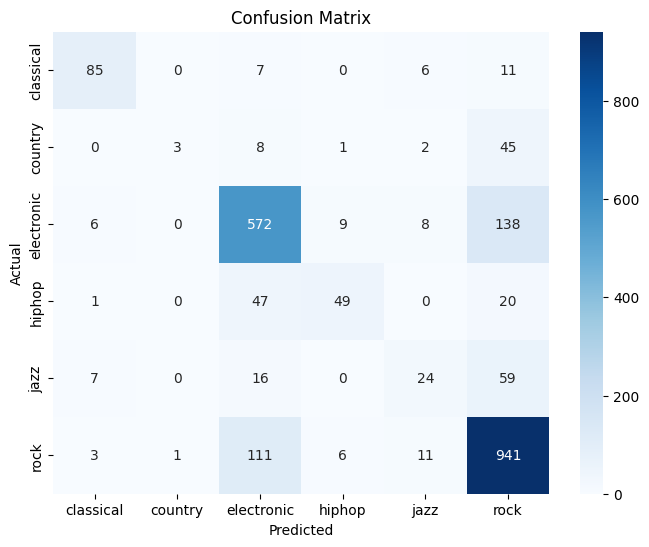

In [4]:
model_1 = ModelEvaluation(model_1_name,model_1_file_name,X_test, y_test, label_encoder)

## Scenario 2: Using Log MelSepctrogram 128X500 feature vector

In [5]:
X_train, X_test, y_train, y_test,label_encoder =get_feature_vecor_data(vector_type = 'log_mel',
                                                        version_string = '006',
                                                        vector_length = 500, 
                                                        apply_normalization = True)

Loading log mel vectors
features shape distribution
1099    10965
1         122
432         1
437         1
353         1
392         1
467         1
201         1
946         1
622         1
Name: count, dtype: int64
total records:  11124
normalized length:  10984
Row Count after label based filter:  11124
Final Row count after label and feature filter:  10984
Unique label count:  6
label data count  10984
applying normaization


In [10]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001}

type(selected_hp)
model_2 = get_2d_cnn(selected_hp)

In [11]:
history = model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32,
    #batch_size=64,
    batch_size = 128,
    #epochs=200,
    epochs = 25,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),

    ]
)

Epoch 1/25
69/69 [==============================] - 282s 4s/step - loss: 1.0076 - accuracy: 0.6538 - val_loss: 1.3461 - val_accuracy: 0.3345
Epoch 2/25
69/69 [==============================] - 275s 4s/step - loss: 0.7626 - accuracy: 0.7276 - val_loss: 1.6782 - val_accuracy: 0.3368
Epoch 3/25
69/69 [==============================] - 265s 4s/step - loss: 0.6396 - accuracy: 0.7699 - val_loss: 2.0028 - val_accuracy: 0.3418
Epoch 4/25
69/69 [==============================] - 266s 4s/step - loss: 0.5211 - accuracy: 0.8103 - val_loss: 1.7253 - val_accuracy: 0.4456
Epoch 5/25
69/69 [==============================] - 282s 4s/step - loss: 0.4214 - accuracy: 0.8498 - val_loss: 1.2852 - val_accuracy: 0.5876
Epoch 6/25
69/69 [==============================] - 260s 4s/step - loss: 0.3411 - accuracy: 0.8798 - val_loss: 1.1307 - val_accuracy: 0.6609
Epoch 7/25
69/69 [==============================] - 234s 3s/step - loss: 0.2733 - accuracy: 0.9047 - val_loss: 0.9652 - val_accuracy: 0.7010
Epoch 8/25
69

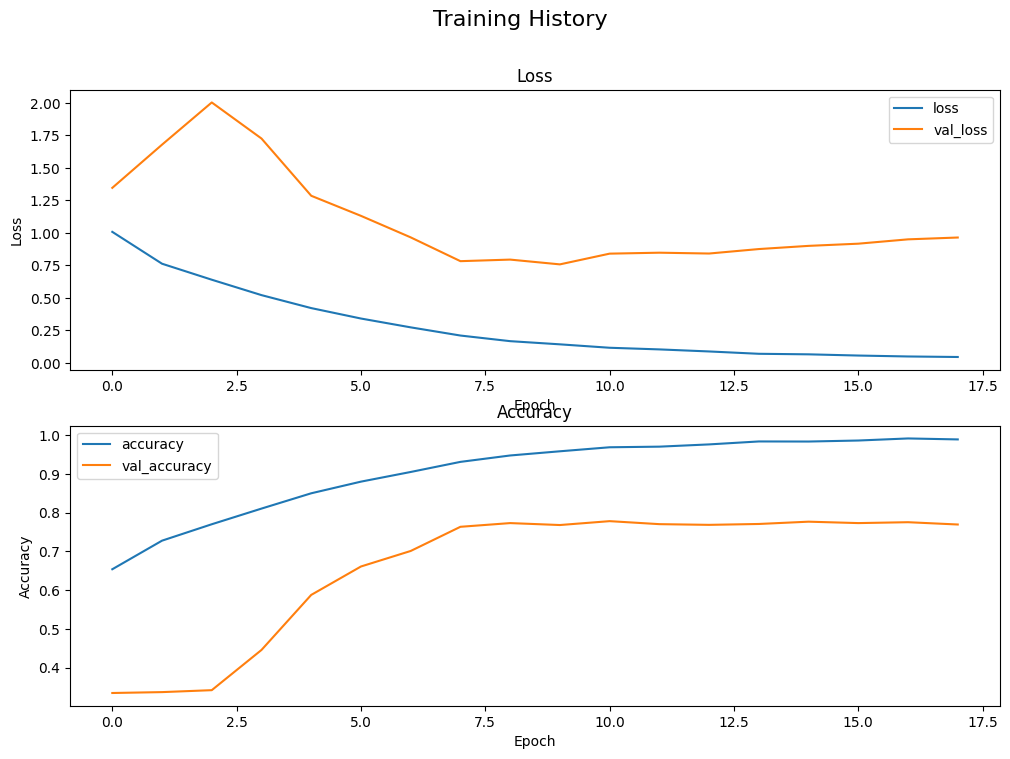

In [14]:
plot_training_history(history)

In [6]:
model_2_name = 'CNN_LogMel'
model_2_file_name = 'v6b_logmel_scaled_128_22500_500_cnn_2d_128_batch_18_epoch_lr_0001.keras'
#model_2.save(SAVED_MODEL_PATH+model_2_file_name)

69/69 [==============================] - 26s 373ms/step
69/69 - 22s - loss: 0.7576 - accuracy: 0.7679 - 22s/epoch - 317ms/step

Test Accuracy: 76.79%
Test Loss: 0.7576

Classification Report:
              precision    recall  f1-score   support

   classical       0.77      0.62      0.69       109
     country       0.45      0.08      0.14        59
  electronic       0.74      0.82      0.78       733
      hiphop       0.75      0.42      0.54       117
        jazz       0.43      0.21      0.28       106
        rock       0.80      0.88      0.84      1073

    accuracy                           0.77      2197
   macro avg       0.66      0.51      0.54      2197
weighted avg       0.75      0.77      0.75      2197



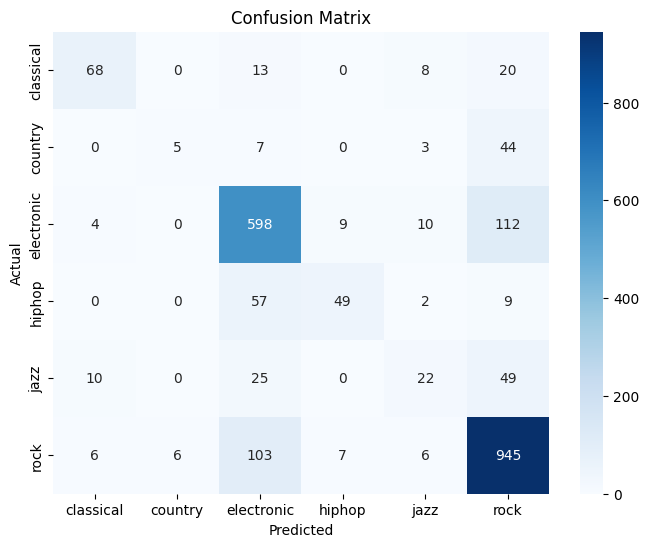

In [7]:
model_2 = ModelEvaluation(model_2_name,model_2_file_name,X_test, y_test, label_encoder)
#model_2 = ModelEvaluation(model_2_file_name,X_test, y_test, label_encoder)

## Comparative Analysis

In [8]:
import pandas as pd
import altair as alt
alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [ ]:
def get_model_evaluation_comparison_data(model_evals, metrics):
    comparison_dfs = {}
    for metric in metrics:
        metric_model_array = []
        for model in model_evals:
            metric_model_array.append(pd.DataFrame(model.classification_report).T[metric])

        comparison_dfs[metric] = pd.concat(metric_model_array, axis=1)
        comparison_dfs[metric].columns = [model.name for model in model_evals]
        comparison_dfs[metric] = comparison_dfs[metric].T
        comparison_dfs[metric].reset_index(inplace=True)
    return comparison_dfs


In [ ]:
metrics = ['precision', 'recall','f1-score']
model_evals = [model_1, model_2]
genres =  model_evals[0].label_encoder.classes_
comparison_dfs = get_model_evaluation_comparison_data(model_evals,metrics)


In [24]:
 alt.Chart(comparison_dfs['precision']).mark_bar().encode(
        x=alt.X('amount:Q', title=None),
        y=alt.Y('type:N', title=None),
        color=alt.Color('amount:Q', legend=None),
        column=alt.Column('index',
                        title=None)).transform_fold(as_=['type', 'amount'],
                                                    fold=genres).properties(
                                                        width=100,
                                                        title=f'Precision by Model')



alt.Chart(...)

In [25]:
 alt.Chart(comparison_dfs['recall']).mark_bar().encode(
        x=alt.X('amount:Q', title=None),
        y=alt.Y('type:N', title=None),
        color=alt.Color('amount:Q', legend=None),
        column=alt.Column('index',
                        title=None)).transform_fold(as_=['type', 'amount'],
                                                    fold=genres).properties(
                                                        width=100,
                                                        title=f'Recall by Model')

alt.Chart(...)

In [26]:
 alt.Chart(comparison_dfs['f1-score']).mark_bar().encode(
        x=alt.X('amount:Q', title=None),
        y=alt.Y('type:N', title=None),
        color=alt.Color('amount:Q', legend=None),
        column=alt.Column('index',
                        title=None)).transform_fold(as_=['type', 'amount'],
                                                    fold=genres).properties(
                                                        width=100,
                                                        title=f'F1 Score by Model')

alt.Chart(...)


#https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.
Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection

Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


f1 = 2 x( (precions*recall)/(recision+recal))

F1 Score is needed when you want to seek a balance between Precision and Recall. Right…so what is the difference between F1 Score and Accuracy then? We have previously seen that accuracy can be largely contributed by a large number of True Negatives which in most business circumstances, we do not focus on much whereas False Negative and False Positive usually has business costs (tangible & intangible) thus F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).



Next Notes: 
xProduce evaluation images and data points for each of the two models, through finishing evaluation functions

xLeft off finishing model evaluation

x-next up:
put it in external file.  

Consider , having separate evaluation specific notebook to include more of the summary insights , whereas this notebook can have the training. 





Create a model eval comparison visual leveraging tetyana's code 
comparative image goes in report describing and comparing the two scenarios vs. tetyana's, and talking about what it took ( cost side)

retrain models in featured notebook, and resave (do more epochs)
Consider approach for parameter tuning 
consider whether to supply validation data from test set OR not (may be incorect )


See if can make the confusion matrix align in order to tetyanas for comparability
